In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from dingo.gw.noise.asd_dataset import ASDDataset
import yaml
import pycbc.psd
import numpy as np

In [2]:
font_value = 20

# Set global Matplotlib settings for a clean look without grids
plt.rcParams['axes.grid'] = False      # Disable grid lines for all axes
plt.rcParams['grid.color'] = 'none'    # Just in case, ensure grid color is invisible
# Set matplotlib to render LaTeX fonts
plt.rcParams.update({
    "mathtext.fontset" : "stix",
    "font.family" : "STIXGeneral",
    "axes.labelsize": font_value ,           # Font size for axis labels
    "axes.titlesize": font_value ,           # Font size for titles
    "font.size": font_value ,                # General font size
    "legend.fontsize": font_value ,          # Font size for legend
    "xtick.labelsize": font_value ,          # Font size for x-axis ticks
    "ytick.labelsize": font_value ,          # Font size for y-axis ticks
})

In [3]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
# Enable retina display output in Jupyter
set_matplotlib_formats("retina")

In [4]:
# I need to create a DingoDataset otherwise it won't be read by training pipeline
#help(DingoDataset)

In [5]:
# you need to understand the details on how you get the ASD for LIGO 
# so you'll know how to to build the ASD for ET
# in the case of LIGO the ASD is evaluated starting from strain data,
# you don't need to do that with ET

# here I think it's the core piece of code:

#                psd = estimate_single_psd(time_start=start, **estimation_kwargs)
#                asd = np.sqrt(psd[domain.min_idx : domain.max_idx + 1])
#                gps_time = start
#
#                dataset_dict["asds"] = {det: np.array([asd])}
#                dataset_dict["gps_times"] = {det: np.array([gps_time])}

# I think I just need to use the asd I have for ET
# is the gps time important? what do I put for ET?

In [6]:
ET_ASD = pd.read_csv('ET_cryo_psd.txt', delimiter = ' ', names = ['frequency', 'PSD'])

In [7]:
ET_ASD

,frequency,PSD
0,1.000000,3.480218e-33
1,1.003076,3.112909e-33
2,1.006161,2.787849e-33
3,1.009256,2.499719e-33
4,1.012360,2.243938e-33
...,...,...
2995,9877.905984,8.627871e-47
2996,9908.289019,8.714538e-47
2997,9938.765509,8.801966e-47
2998,9969.335739,8.890155e-47


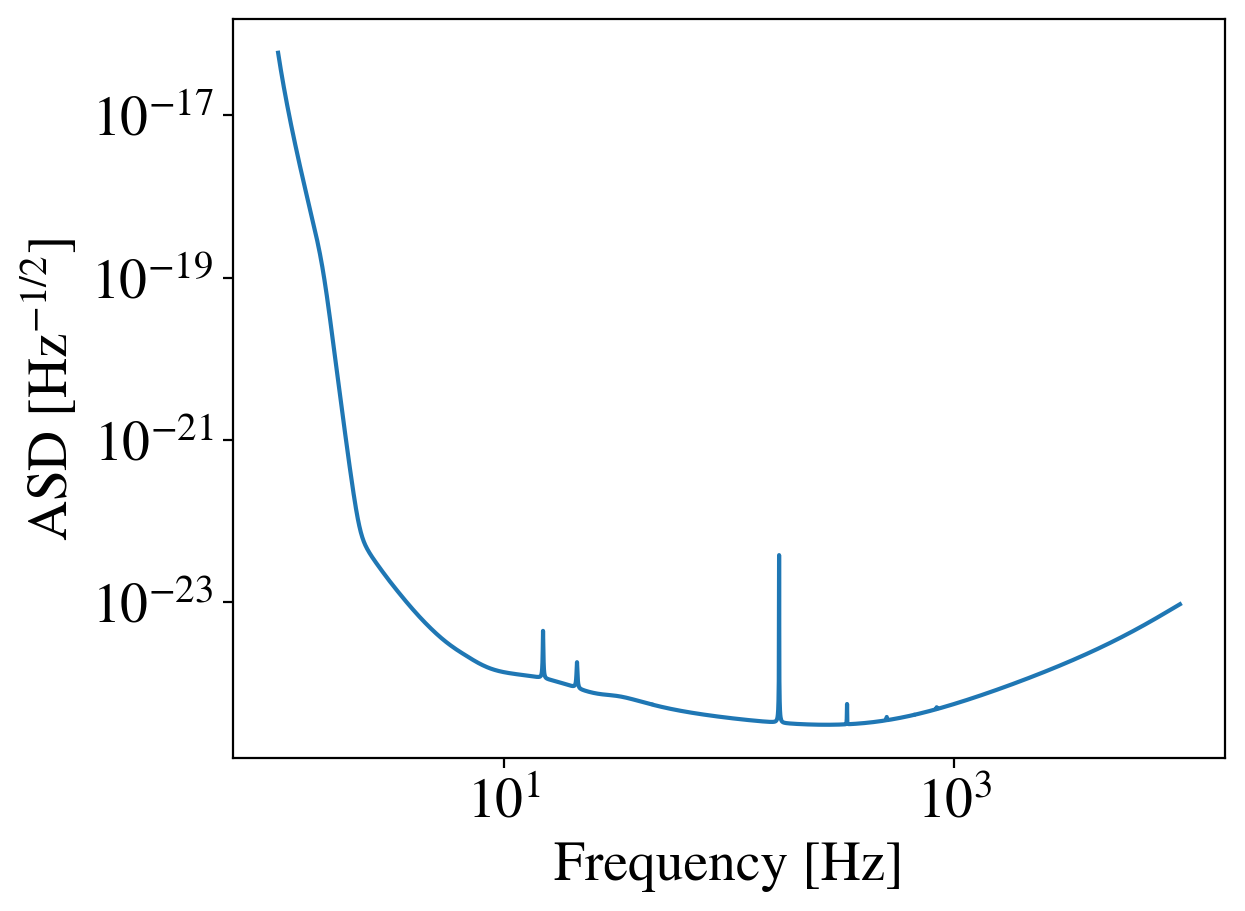

In [8]:
ET_ASD['ASD'] = np.sqrt(ET_ASD['PSD'])



plt.plot(ET_ASD['frequency'],ET_ASD['ASD'])

plt.yscale('log')
plt.xscale('log')

plt.ylabel('ASD [Hz$^{-1/2}$]')
plt.xlabel('Frequency [Hz]')

plt.show()

In [9]:
ET_ASD

,frequency,PSD,ASD
0,1.000000,3.480218e-33,5.899337e-17
1,1.003076,3.112909e-33,5.579345e-17
2,1.006161,2.787849e-33,5.280008e-17
3,1.009256,2.499719e-33,4.999719e-17
4,1.012360,2.243938e-33,4.737023e-17
...,...,...,...
2995,9877.905984,8.627871e-47,9.288633e-24
2996,9908.289019,8.714538e-47,9.335169e-24
2997,9938.765509,8.801966e-47,9.381879e-24
2998,9969.335739,8.890155e-47,9.428762e-24


In [10]:
ET_ASD_tosave = ET_ASD.drop('PSD', axis = 1)

In [11]:
ET_ASD_tosave

,frequency,ASD
0,1.000000,5.899337e-17
1,1.003076,5.579345e-17
2,1.006161,5.280008e-17
3,1.009256,4.999719e-17
4,1.012360,4.737023e-17
...,...,...
2995,9877.905984,9.288633e-24
2996,9908.289019,9.335169e-24
2997,9938.765509,9.381879e-24
2998,9969.335739,9.428762e-24


In [12]:
ET_ASD_tosave.to_csv('ET_cryo_asd.txt', sep = ' ',index=False,header=False)

In [13]:
# it's not clear to me if the number of samples is important...

In [14]:
# I create the asd file in the case of ET

f_ET = h5py.File('asds_ET.hdf5', 'w')

In [15]:
# ['asds', 'gps_times', 'version']
f_ET.create_group('asds')

<HDF5 group "/asds" (0 members)>

In [16]:
# I need to resample ET PSD accordingly on how I sampled the waveform in the frequency domain
# that is I need the same number of samples
# 16336 
# 16385 ---> where this number comes from? 2048/0.125 = 16384 + 1, found it!

length_here = int(2048 / 0.125) + 1
print(length_here)
new_ASD_et = pycbc.psd.read.from_numpy_arrays(ET_ASD['frequency'].to_numpy(),
                                              ET_ASD['ASD'].to_numpy(),
                        length=length_here, delta_f=0.125,
                        low_freq_cutoff=1)


16385


In [17]:
print(new_ASD_et)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.11884295e-24
 1.11891507e-24 1.11898719e-24]


In [18]:
print(new_ASD_et.shape)

(16385,)


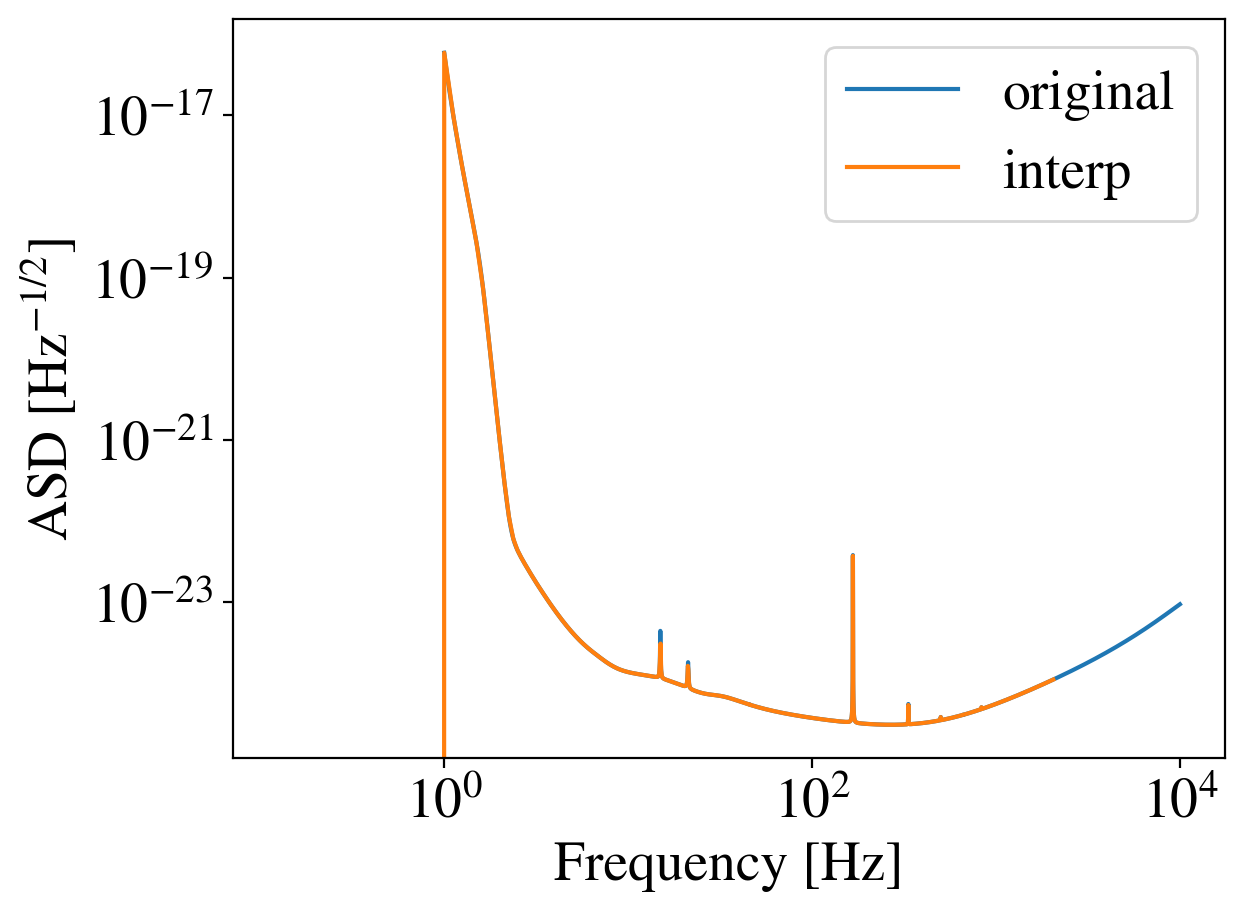

In [19]:
plt.plot(ET_ASD['frequency'],ET_ASD['ASD'], label = 'original')

# it starts from freq 0
new_freq = np.linspace(0,2048,16385)

plt.plot(new_freq,new_ASD_et, label = 'interp')

#plt.xlim([1,2048])
#plt.ylim([1e-25,1e-22])

plt.yscale('log')
plt.xscale('log')

plt.ylabel('ASD [Hz$^{-1/2}$]')
plt.xlabel('Frequency [Hz]')

plt.legend()

plt.show()

In [20]:
new_ASD_et[new_freq == 1]

array([5.89933693e-17])

In [21]:
new_freq[2]-new_freq[1]

0.125

In [22]:
new_freq

array([0.000000e+00, 1.250000e-01, 2.500000e-01, ..., 2.047750e+03,
       2.047875e+03, 2.048000e+03])

In [23]:
#f_ET['asds'].create_dataset('ET', data=ET_ASD['ASD'].values.reshape(1, 3000))
##<HDF5 dataset "H1": shape (1, 16385), type "<f8">

In [24]:
#f_ET['asds']['ET'][()]

In [25]:
#f_ET['asds'].keys()

In [26]:
#f_ET.create_group('gps_times')

In [27]:
#f_ET['gps_times'].create_dataset('ET', data=(1126073529,))
##<HDF5 dataset "H1": shape (1,), type "<i8">

In [28]:
#f_ET['gps_times']['ET']

In [29]:
#f_ET.create_dataset('version', data='dingo=0.5.11')
##<HDF5 dataset "version": shape (), type "|O">

In [30]:
#f_ET['version'][()]

In [31]:
#f_ET.close()

In [32]:
f_ET = h5py.File('asds_ET.hdf5', 'r')

In [33]:
# I don't understand the meaning of some of these parameters         
settings = {"dataset_settings": {"T": 8.0, "detectors": ["ET-dingo1", "ET-dingo2", "ET-dingo3"], "f_s": 4096, 
                                 "num_psds_max": 1, #if set > 0, only a subset of all available PSDs will be used
                                 "observing_run": None ,
            "time_gap": 0, "time_psd": 1024, "window": {"roll_off": 0.4, "type": "tukey"}}, 
            "domain_dict": {
            "delta_f": 0.125, "f_max": 2048.0, "f_min": 6.0, "type": "FrequencyDomain", "window_factor": None}}

ET_dict = {"asds": {}, "gps_times": {}}

ET_dict["settings"] = settings

### option 1
##if you do this, you get "ValueError: Detectors of strain data, dict_keys(['ET-dingo1', 'ET-dingo2', 'ET-dingo3']), do not match those of asds, dict_keys([ET-dingo])."
#ET_dict["asds"]['ET-dingo'] = np.array(new_ASD_et).reshape(1,16385)
#ET_dict["gps_times"]['ET-dingo'] = 1126073529

## option 2
# if you do this, you get "ValueError: Detectors of strain data, dict_keys(['ET-dingo1', 'ET-dingo2', 'ET-dingo3']), do not match those of asds, dict_keys([])."
# I hacked train_builders.py and this work!
ET_dict["asds"]['ET-dingo1'] = np.array(new_ASD_et).reshape(1,16385)
ET_dict["asds"]['ET-dingo2'] = np.array(new_ASD_et).reshape(1,16385)
ET_dict["asds"]['ET-dingo3'] = np.array(new_ASD_et).reshape(1,16385)
# equal to the reference time in training setting -> I don't know if this is correct!
ET_dict["gps_times"]['ET-dingo1'] = 1126259462.391
ET_dict["gps_times"]['ET-dingo2'] = 1126259462.391
ET_dict["gps_times"]['ET-dingo3'] = 1126259462.391  #1126073529

## option 3
# if you do this, you get "AttributeError: 'dict' object has no attribute 'shape'"
#ET_dict["asds"]['ET-dingo'] = {
#    '1' : np.array(new_ASD_et).reshape(1,16385),
#    '2' : np.array(new_ASD_et).reshape(1,16385),
#    '3' : np.array(new_ASD_et).reshape(1,16385)
#}
#ET_dict["gps_times"]['ET-dingo'] = {
#    '1' : 1126073529,
#    '2' : 1126073529,
#    '3' : 1126073529
#}


#print(ET_dict)

dataset = ASDDataset(dictionary=ET_dict) 
filename ='asds_ET_working.hdf5' 
dataset.to_file(filename)

In [34]:
## Create an instance of DingoDataset
asd_dataset_ET = ASDDataset(file_name = 'asds_ET_working.hdf5')

In [35]:
print(f"Dingo version: {asd_dataset_ET.version}")
print("\nASD dataset\n" + "================\n")

print(f"Dataset size: {asd_dataset_ET.length_info}\n")
print(f"GPS times (min/max): {asd_dataset_ET.gps_info}")

print(
    "\nSettings\n"
    + "--------\n"
    + yaml.dump(
        asd_dataset_ET.settings,
        default_flow_style=False,
        sort_keys=False,
    )
)

Dingo version: dingo=0.1.dev1015+gbf2c41f

ASD dataset

Dataset size: {'ET-dingo1': 1, 'ET-dingo2': 1, 'ET-dingo3': 1}

GPS times (min/max): {'ET-dingo1': 1126259462.391, 'ET-dingo2': 1126259462.391, 'ET-dingo3': 1126259462.391}

Settings
--------
dataset_settings:
  T: 8.0
  detectors:
  - ET-dingo1
  - ET-dingo2
  - ET-dingo3
  f_s: 4096
  num_psds_max: 1
  observing_run: null
  time_gap: 0
  time_psd: 1024
  window:
    roll_off: 0.4
    type: tukey
domain_dict:
  delta_f: 0.125
  f_max: 2048.0
  f_min: 6.0
  type: FrequencyDomain
  window_factor: null



In [36]:
asd_dataset_ET.asds['ET-dingo1']

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.11884295e-24, 1.11891507e-24, 1.11898719e-24]])

In [37]:
asd_dataset_ET.asds['ET-dingo1'] == 0


array([[ True,  True,  True, ..., False, False, False]])

In [38]:
# I need to resample ET PSD accordingly on how I sampled the waveform in the frequency domain
# that is I need the same number of samples

length_here_lower_max_freq = int(256 / 0.125) + 1
print(length_here_lower_max_freq)
new_ASD_et_lower_max_freq = pycbc.psd.read.from_numpy_arrays(ET_ASD['frequency'].to_numpy(),
                                              ET_ASD['ASD'].to_numpy(),
                        length=length_here_lower_max_freq, delta_f=0.125,
                        low_freq_cutoff=6)


2049


In [39]:
# set settings      
settings = {"dataset_settings": {"T": 8.0, "detectors": ["ET-dingo1", "ET-dingo2", "ET-dingo3"], "f_s": 4096, 
                                 "num_psds_max": 1, #if set > 0, only a subset of all available PSDs will be used
                                 "observing_run": None ,
            "time_gap": 0, "time_psd": 1024, "window": {"roll_off": 0.4, "type": "tukey"}}, 
            "domain_dict": {
            "delta_f": 0.125, "f_max": 256.0, "f_min": 6.0, "type": "FrequencyDomain", "window_factor": None}}

ET_dict = {"asds": {}, "gps_times": {}}

ET_dict["settings"] = settings

### option 1
##if you do this, you get "ValueError: Detectors of strain data, dict_keys(['ET-dingo1', 'ET-dingo2', 'ET-dingo3']), do not match those of asds, dict_keys([ET-dingo])."
#ET_dict["asds"]['ET-dingo'] = np.array(new_ASD_et).reshape(1,16385)
#ET_dict["gps_times"]['ET-dingo'] = 1126073529

## option 2
# if you do this, you get "ValueError: Detectors of strain data, dict_keys(['ET-dingo1', 'ET-dingo2', 'ET-dingo3']), do not match those of asds, dict_keys([])."
# I hacked train_builders.py and this work!
ET_dict["asds"]['ET-dingo1'] = np.array(new_ASD_et_lower_max_freq).reshape(1,2049)
ET_dict["asds"]['ET-dingo2'] = np.array(new_ASD_et_lower_max_freq).reshape(1,2049)
ET_dict["asds"]['ET-dingo3'] = np.array(new_ASD_et_lower_max_freq).reshape(1,2049)
# equal to the reference time in training setting -> I don't know if this is correct!
ET_dict["gps_times"]['ET-dingo1'] = 1126259462.391
ET_dict["gps_times"]['ET-dingo2'] = 1126259462.391
ET_dict["gps_times"]['ET-dingo3'] = 1126259462.391  #1126073529

#print(ET_dict)

dataset = ASDDataset(dictionary=ET_dict) 
filename ='asds_ET_working_ref_time_lower_max_freq.hdf5' 
dataset.to_file(filename)

In [40]:
asd_dataset_ET_2 = ASDDataset(file_name = 'asds_ET_working_ref_time_lower_max_freq.hdf5' )
print(f"Dingo version: {asd_dataset_ET_2.version}")
print("\nASD dataset\n" + "================\n")

print(f"Dataset size: {asd_dataset_ET_2.length_info}\n")
print(f"GPS times (min/max): {asd_dataset_ET_2.gps_info}")

print(
    "\nSettings\n"
    + "--------\n"
    + yaml.dump(
        asd_dataset_ET_2.settings,
        default_flow_style=False,
        sort_keys=False,
    )
)

Dingo version: dingo=0.1.dev1015+gbf2c41f

ASD dataset

Dataset size: {'ET-dingo1': 1, 'ET-dingo2': 1, 'ET-dingo3': 1}

GPS times (min/max): {'ET-dingo1': 1126259462.391, 'ET-dingo2': 1126259462.391, 'ET-dingo3': 1126259462.391}

Settings
--------
dataset_settings:
  T: 8.0
  detectors:
  - ET-dingo1
  - ET-dingo2
  - ET-dingo3
  f_s: 4096
  num_psds_max: 1
  observing_run: null
  time_gap: 0
  time_psd: 1024
  window:
    roll_off: 0.4
    type: tukey
domain_dict:
  delta_f: 0.125
  f_max: 256.0
  f_min: 6.0
  type: FrequencyDomain
  window_factor: null



In [41]:
asd_dataset_ET_2.asds['ET-dingo1']

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.10603975e-25, 3.10599326e-25, 3.10594679e-25]])

In [42]:
# dingo_ls does not work on the file I created... is this a problem? Yes!
# when training is launched it looks for data that are not there...

In [43]:
# what is the difference between ASD and PSD? ASD is the square root of PSD

In [44]:
# check if SVD has gone all right with waveform generation for ET: it is!

# check the waveform_dataset that has been generated! I don't know exactly what to look at
# these are compressed waveforms though with SVD

In [45]:
# I need to use exactly the same ASD I used in Bilby 

########
# window factor is equal to 1 in your Bilby runs. 
########

new_ASD_et_lower_max_freq_bilby = pd.read_csv('../Bilby_runs/event_2.7/result/ET-dingo1_asd.dat', skiprows = 1, names = ['f', 'h(f)'], delimiter = ' ')


ind_freq = new_ASD_et_lower_max_freq_bilby['f'] <= 256
print('number of frequency bins = ', len(new_ASD_et_lower_max_freq_bilby.loc[ind_freq]))

print(new_ASD_et_lower_max_freq_bilby.loc[ind_freq])

# assign another value instead -inf to < f_min
#new_ASD_et_lower_max_freq_bilby.loc[new_ASD_et_lower_max_freq_bilby['f'] < 6, 'h(f)'] = 100


# set settings      
settings = {"dataset_settings": {"T": 8.0, "detectors": ["ET-dingo1", "ET-dingo2", "ET-dingo3"], "f_s": 4096, 
                                 "num_psds_max": 1, #if set > 0, only a subset of all available PSDs will be used
                                 "observing_run": None ,
                                 
            "time_gap": 0, "time_psd": 1024, "window": {"roll_off": 0.2, "type": "NoWindowFactor"}}, # with window type "NoWindowFactor", window_factor is set to 1 to match what in Bilby and roll_off also equal to Bilby
            "domain_dict": {
            "delta_f": 0.125, "f_max": 256.0, "f_min": 6.0, "type": "FrequencyDomain", "window_factor": None}}

ET_dict = {"asds": {}, "gps_times": {}}

ET_dict["settings"] = settings

### option 1
##if you do this, you get "ValueError: Detectors of strain data, dict_keys(['ET-dingo1', 'ET-dingo2', 'ET-dingo3']), do not match those of asds, dict_keys([ET-dingo])."
#ET_dict["asds"]['ET-dingo'] = np.array(new_ASD_et).reshape(1,16385)
#ET_dict["gps_times"]['ET-dingo'] = 1126073529

## option 2
# if you do this, you get "ValueError: Detectors of strain data, dict_keys(['ET-dingo1', 'ET-dingo2', 'ET-dingo3']), do not match those of asds, dict_keys([])."
# I hacked train_builders.py and this work!
ET_dict["asds"]['ET-dingo1'] = np.array(new_ASD_et_lower_max_freq_bilby['h(f)'].loc[ind_freq]).reshape(1,2049)
ET_dict["asds"]['ET-dingo2'] = np.array(new_ASD_et_lower_max_freq_bilby['h(f)'].loc[ind_freq]).reshape(1,2049)
ET_dict["asds"]['ET-dingo3'] = np.array(new_ASD_et_lower_max_freq_bilby['h(f)'].loc[ind_freq]).reshape(1,2049)
# equal to the reference time in training setting -> I don't know if this is correct!
ET_dict["gps_times"]['ET-dingo1'] = 1126259462.391
ET_dict["gps_times"]['ET-dingo2'] = 1126259462.391
ET_dict["gps_times"]['ET-dingo3'] = 1126259462.391  #1126073529

#print(ET_dict)

dataset = ASDDataset(dictionary=ET_dict) 
filename ='asds_ET_working_ref_time_lower_max_freq_bilby.hdf5' 
dataset.to_file(filename)

asd_dataset_ET_bilby = ASDDataset(file_name = 'asds_ET_working_ref_time_lower_max_freq_bilby.hdf5' )
print(f"Dingo version: {asd_dataset_ET_bilby.version}")
print("\nASD dataset\n" + "================\n")

print(f"Dataset size: {asd_dataset_ET_bilby.length_info}\n")
print(f"GPS times (min/max): {asd_dataset_ET_bilby.gps_info}")

print(
    "\nSettings\n"
    + "--------\n"
    + yaml.dump(
        asd_dataset_ET_bilby.settings,
        default_flow_style=False,
        sort_keys=False,
    )
)

number of frequency bins =  2049
            f          h(f)
0       0.000           inf
1       0.125           inf
2       0.250           inf
3       0.375           inf
4       0.500           inf
...       ...           ...
2044  255.500  3.106134e-25
2045  255.625  3.106086e-25
2046  255.750  3.106040e-25
2047  255.875  3.105993e-25
2048  256.000  3.105947e-25

[2049 rows x 2 columns]
Dingo version: dingo=0.1.dev1015+gbf2c41f

ASD dataset

Dataset size: {'ET-dingo1': 1, 'ET-dingo2': 1, 'ET-dingo3': 1}

GPS times (min/max): {'ET-dingo1': 1126259462.391, 'ET-dingo2': 1126259462.391, 'ET-dingo3': 1126259462.391}

Settings
--------
dataset_settings:
  T: 8.0
  detectors:
  - ET-dingo1
  - ET-dingo2
  - ET-dingo3
  f_s: 4096
  num_psds_max: 1
  observing_run: null
  time_gap: 0
  time_psd: 1024
  window:
    roll_off: 0.2
    type: NoWindowFactor
domain_dict:
  delta_f: 0.125
  f_max: 256.0
  f_min: 6.0
  type: FrequencyDomain
  window_factor: null



In [46]:
asd_dataset_ET_bilby.domain.sample_frequencies

array([0.00000e+00, 1.25000e-01, 2.50000e-01, ..., 2.55750e+02,
       2.55875e+02, 2.56000e+02], dtype=float32)

In [47]:
asd_dataset_ET_bilby.asds['ET-dingo1'][0]

array([           inf,            inf,            inf, ...,
       3.10603984e-25, 3.10599337e-25, 3.10594690e-25])

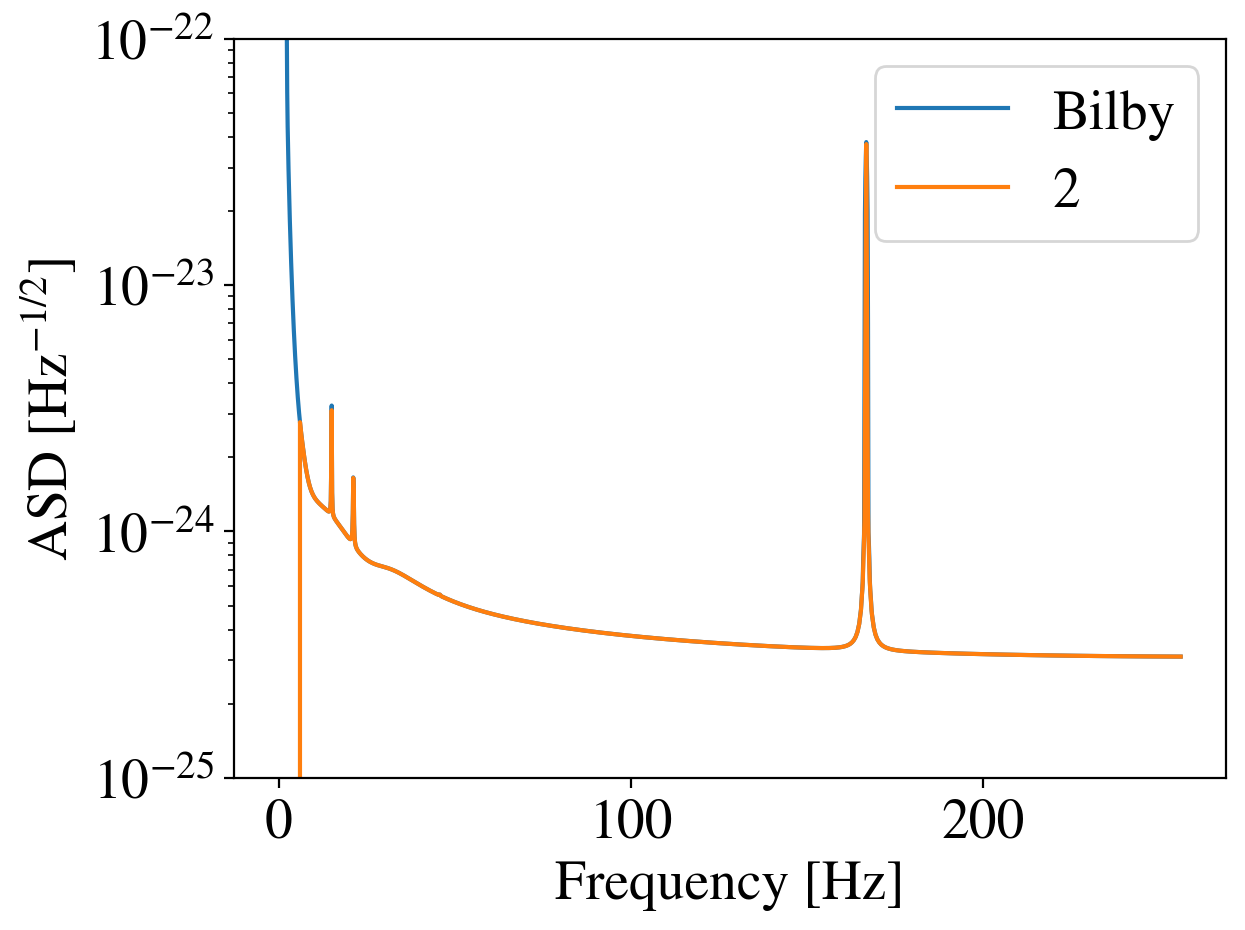

In [48]:
plt.plot(asd_dataset_ET_bilby.domain.sample_frequencies,asd_dataset_ET_bilby.asds['ET-dingo1'][0], 
        label = 'Bilby')
plt.plot(asd_dataset_ET_2.domain.sample_frequencies,asd_dataset_ET_2.asds['ET-dingo1'][0], 
        label = '2')

plt.yscale('log')
plt.legend()
#plt.xlim([0,256])

plt.ylabel('ASD [Hz$^{-1/2}$]')
plt.xlabel('Frequency [Hz]')

plt.ylim([1e-25,1e-22])
plt.show()

In [49]:
# repeating what has been done above for ET-2L

# I need to use exactly the same ASD I used in Bilby 

########
# window factor is equal to 1 in your Bilby runs. 
########

ASD_bilby_1L_IT = pd.read_csv('../CheckBilbyRuns/CheckEvent252/result_event_252_nessai_ET2L/ET_1L_IT_asd.dat', skiprows = 1, names = ['f', 'h(f)'], delimiter = ' ')

ASD_bilby_1L_NL = pd.read_csv('../CheckBilbyRuns/CheckEvent252/result_event_252_nessai_ET2L/ET_1L_NL_asd.dat', skiprows = 1, names = ['f', 'h(f)'], delimiter = ' ')


ind_freq = ASD_bilby_1L_IT['f'] <= 256
print('number of frequency bins = ', len(ASD_bilby_1L_IT.loc[ind_freq]))

print(ASD_bilby_1L_IT.loc[ind_freq])

#
# set settings      
settings = {"dataset_settings": {"T": 8.0, "detectors": ["ET_1L_IT", "ET_1L_NL"], "f_s": 4096, 
                                 "num_psds_max": 1, #if set > 0, only a subset of all available PSDs will be used
                                 "observing_run": None ,
                                 
            "time_gap": 0, "time_psd": 1024, "window": {"roll_off": None, "type": "NoWindowFactor"}}, # with window type "NoWindowFactor", window_factor is set to 1 to match what in Bilby and roll_off also equal to Bilby
            "domain_dict": {
            "delta_f": 0.125, "f_max": 256.0, "f_min": 6.0, "type": "FrequencyDomain", "window_factor": None}}

ET_dict = {"asds": {}, "gps_times": {}}

ET_dict["settings"] = settings

#
# I hacked train_builders.py and now works!
ET_dict["asds"]['ET_1L_IT'] = np.array(ASD_bilby_1L_IT['h(f)'].loc[ind_freq]).reshape(1,2049)
ET_dict["asds"]['ET_1L_NL'] = np.array(ASD_bilby_1L_NL['h(f)'].loc[ind_freq]).reshape(1,2049)

# equal to the reference time in training setting -> I don't know if this is correct!
ET_dict["gps_times"]['ET_1L_IT'] = 1126259462.391
ET_dict["gps_times"]['ET_1L_NL'] = 1126259462.391


#print(ET_dict)

dataset = ASDDataset(dictionary=ET_dict) 
filename ='asds_ET_working_ref_time_lower_max_freq_bilby_2L.hdf5' 
dataset.to_file(filename)

asd_dataset_ET_bilby_2L = ASDDataset(file_name = filename)
print(f"Dingo version: {asd_dataset_ET_bilby_2L.version}")
print("\nASD dataset\n" + "================\n")

print(f"Dataset size: {asd_dataset_ET_bilby_2L.length_info}\n")
print(f"GPS times (min/max): {asd_dataset_ET_bilby_2L.gps_info}")

print(
    "\nSettings\n"
    + "--------\n"
    + yaml.dump(
        asd_dataset_ET_bilby_2L.settings,
        default_flow_style=False,
        sort_keys=False,
    )
)


number of frequency bins =  2049
            f          h(f)
0       0.000           inf
1       0.125           inf
2       0.250           inf
3       0.375           inf
4       0.500           inf
...       ...           ...
2044  255.500  2.301429e-25
2045  255.625  2.301502e-25
2046  255.750  2.301577e-25
2047  255.875  2.301651e-25
2048  256.000  2.301725e-25

[2049 rows x 2 columns]
Dingo version: dingo=0.1.dev1015+gbf2c41f

ASD dataset

Dataset size: {'ET_1L_IT': 1, 'ET_1L_NL': 1}

GPS times (min/max): {'ET_1L_IT': 1126259462.391, 'ET_1L_NL': 1126259462.391}

Settings
--------
dataset_settings:
  T: 8.0
  detectors:
  - ET_1L_IT
  - ET_1L_NL
  f_s: 4096
  num_psds_max: 1
  observing_run: null
  time_gap: 0
  time_psd: 1024
  window:
    roll_off: null
    type: NoWindowFactor
domain_dict:
  delta_f: 0.125
  f_max: 256.0
  f_min: 6.0
  type: FrequencyDomain
  window_factor: null



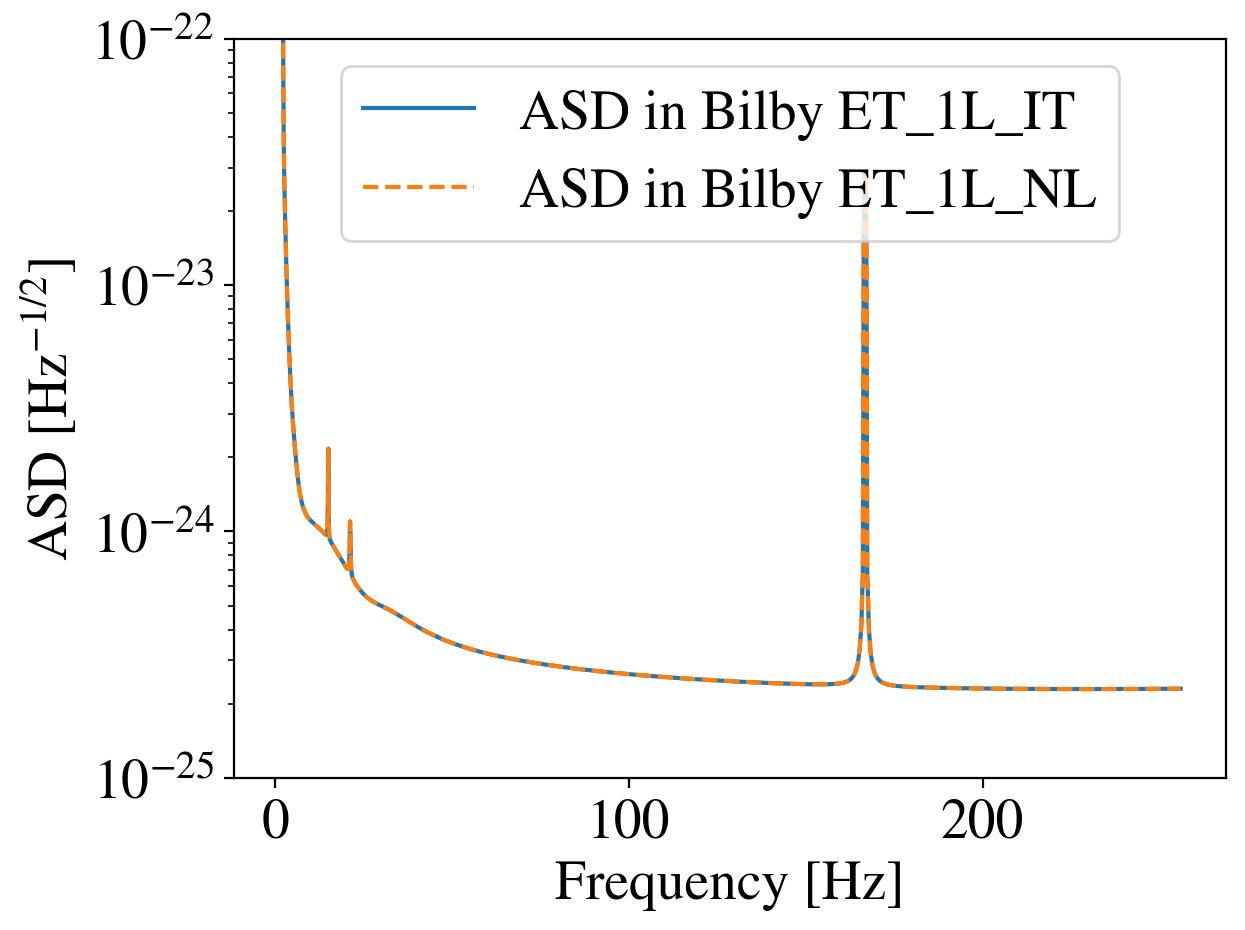

In [50]:
plt.plot(asd_dataset_ET_bilby.domain.sample_frequencies,asd_dataset_ET_bilby_2L.asds['ET_1L_IT'][0], 
        label = 'ASD in Bilby ET_1L_IT')

plt.plot(asd_dataset_ET_bilby.domain.sample_frequencies,asd_dataset_ET_bilby_2L.asds['ET_1L_NL'][0], 
        label = 'ASD in Bilby ET_1L_NL', ls = '--')


plt.yscale('log')
plt.legend(loc = 'upper center')
#plt.xlim([0,256])

plt.ylabel('ASD [Hz$^{-1/2}$]')
plt.xlabel('Frequency [Hz]')

plt.ylim([1e-25,1e-22])
plt.show()

In [51]:
# repeating what has been done above for ET-2L A

# I need to use exactly the same ASD I used in Bilby 

########
# window factor is equal to 1 in your Bilby runs. 
########

ASD_bilby_1L_IT = pd.read_csv('../../2Ls/ETDelta_ET2L/result_event_252_nessai_ET2L_A_zeronoise/ET_1L_IT_asd.dat', skiprows = 1, names = ['f', 'h(f)'], delimiter = ' ')

ASD_bilby_1L_NL = pd.read_csv('../../2Ls/ETDelta_ET2L/result_event_252_nessai_ET2L_A_zeronoise/ET_1L_NL_A_asd.dat', skiprows = 1, names = ['f', 'h(f)'], delimiter = ' ')


ind_freq = ASD_bilby_1L_IT['f'] <= 256
print('number of frequency bins = ', len(ASD_bilby_1L_IT.loc[ind_freq]))

print(ASD_bilby_1L_IT.loc[ind_freq])

#
# set settings      
settings = {"dataset_settings": {"T": 8.0, "detectors": ["ET_1L_IT", "ET_1L_NL_A"], "f_s": 4096, 
                                 "num_psds_max": 1, #if set > 0, only a subset of all available PSDs will be used
                                 "observing_run": None ,
                                 
            "time_gap": 0, "time_psd": 1024, "window": {"roll_off": None, "type": "NoWindowFactor"}}, # with window type "NoWindowFactor", window_factor is set to 1 to match what in Bilby and roll_off also equal to Bilby
            "domain_dict": {
            "delta_f": 0.125, "f_max": 256.0, "f_min": 6.0, "type": "FrequencyDomain", "window_factor": None}}

ET_dict = {"asds": {}, "gps_times": {}}

ET_dict["settings"] = settings

#
# I hacked train_builders.py and now works!
ET_dict["asds"]['ET_1L_IT'] = np.array(ASD_bilby_1L_IT['h(f)'].loc[ind_freq]).reshape(1,2049)
ET_dict["asds"]['ET_1L_NL_A'] = np.array(ASD_bilby_1L_NL['h(f)'].loc[ind_freq]).reshape(1,2049)

# equal to the reference time in training setting -> I don't know if this is correct!
ET_dict["gps_times"]['ET_1L_IT'] = 1126259462.391
ET_dict["gps_times"]['ET_1L_NL_A'] = 1126259462.391


#print(ET_dict)

dataset = ASDDataset(dictionary=ET_dict) 
filename ='asds_ET_working_ref_time_lower_max_freq_bilby_2L_A.hdf5' 
dataset.to_file(filename)

asd_dataset_ET_bilby_2L_A = ASDDataset(file_name = filename)
print(f"Dingo version: {asd_dataset_ET_bilby_2L_A.version}")
print("\nASD dataset\n" + "================\n")

print(f"Dataset size: {asd_dataset_ET_bilby_2L_A.length_info}\n")
print(f"GPS times (min/max): {asd_dataset_ET_bilby_2L_A.gps_info}")

print(
    "\nSettings\n"
    + "--------\n"
    + yaml.dump(
        asd_dataset_ET_bilby_2L_A.settings,
        default_flow_style=False,
        sort_keys=False,
    )
)


number of frequency bins =  2049
            f          h(f)
0       0.000           inf
1       0.125           inf
2       0.250           inf
3       0.375           inf
4       0.500           inf
...       ...           ...
2044  255.500  2.301429e-25
2045  255.625  2.301502e-25
2046  255.750  2.301577e-25
2047  255.875  2.301651e-25
2048  256.000  2.301725e-25

[2049 rows x 2 columns]
Dingo version: dingo=0.1.dev1015+gbf2c41f

ASD dataset

Dataset size: {'ET_1L_IT': 1, 'ET_1L_NL_A': 1}

GPS times (min/max): {'ET_1L_IT': 1126259462.391, 'ET_1L_NL_A': 1126259462.391}

Settings
--------
dataset_settings:
  T: 8.0
  detectors:
  - ET_1L_IT
  - ET_1L_NL_A
  f_s: 4096
  num_psds_max: 1
  observing_run: null
  time_gap: 0
  time_psd: 1024
  window:
    roll_off: null
    type: NoWindowFactor
domain_dict:
  delta_f: 0.125
  f_max: 256.0
  f_min: 6.0
  type: FrequencyDomain
  window_factor: null



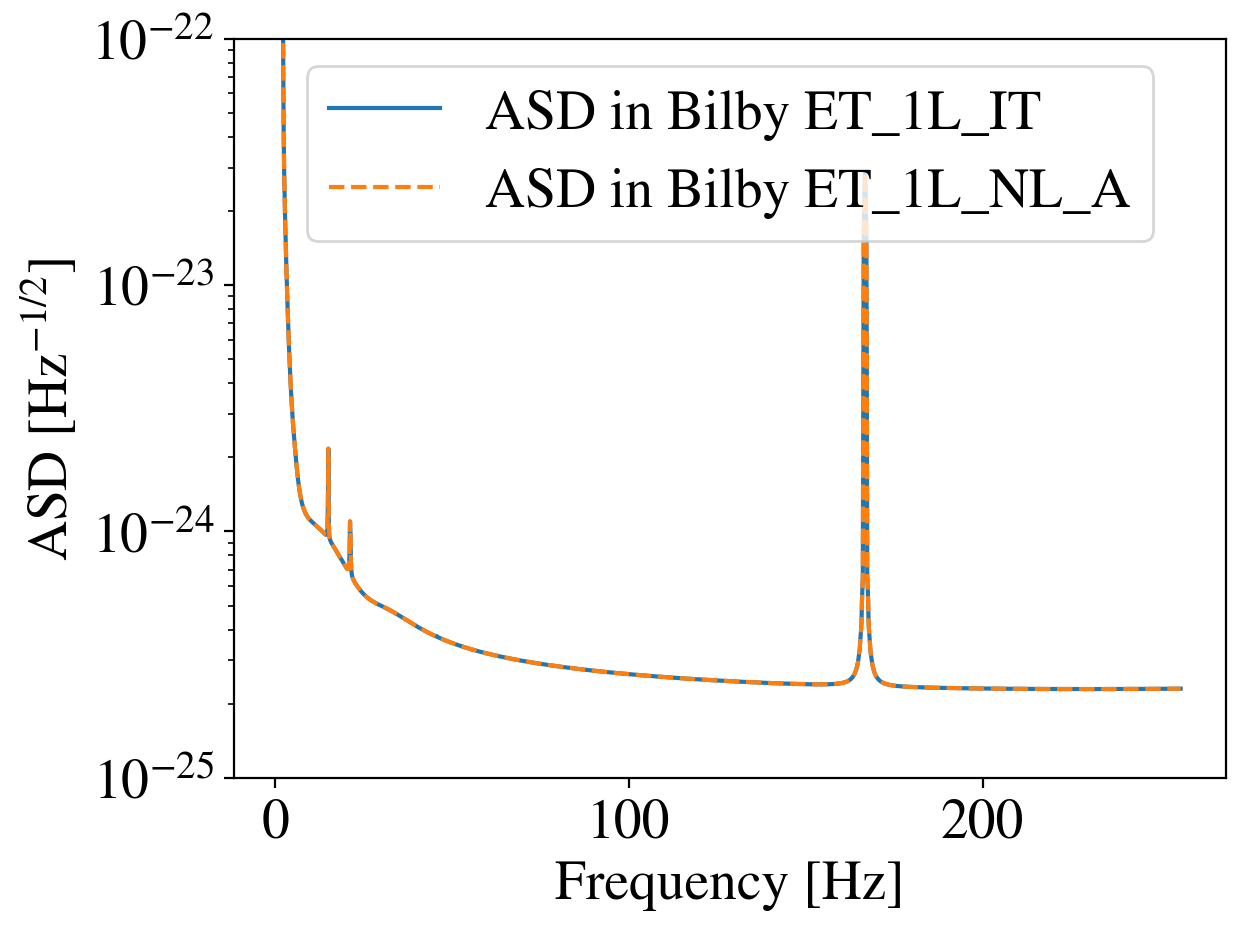

In [52]:
plt.plot(asd_dataset_ET_bilby.domain.sample_frequencies,asd_dataset_ET_bilby_2L_A.asds['ET_1L_IT'][0], 
        label = 'ASD in Bilby ET_1L_IT')

plt.plot(asd_dataset_ET_bilby.domain.sample_frequencies,asd_dataset_ET_bilby_2L_A.asds['ET_1L_NL_A'][0], 
        label = 'ASD in Bilby ET_1L_NL_A', ls = '--')


plt.yscale('log')
plt.legend(loc = 'upper center')
#plt.xlim([0,256])

plt.ylabel('ASD [Hz$^{-1/2}$]')
plt.xlabel('Frequency [Hz]')

plt.ylim([1e-25,1e-22])
plt.show()

In [53]:
# repeating for ET-CE what has been done above for ET-2L A

# I need to use exactly the same ASD I used in Bilby 

########
# window factor is equal to 1 in my Bilby runs. 
########

ASD_bilby_ET = pd.read_csv('../../2Ls/ETDelta_ET2L/result_event_252_nessai_ET_CE_c_zeronoise/ET_1L_IT_asd.dat', skiprows = 1, names = ['f', 'h(f)'], delimiter = ' ')

ASD_bilby_CE = pd.read_csv('../../2Ls/ETDelta_ET2L/result_event_252_nessai_ET_CE_c_zeronoise/CE_1L_H_c_asd.dat', skiprows = 1, names = ['f', 'h(f)'], delimiter = ' ')


ind_freq = ASD_bilby_ET['f'] <= 256
print('number of frequency bins = ', len(ASD_bilby_ET.loc[ind_freq]))
print(ASD_bilby_ET.loc[ind_freq])

#
# set settings      
settings = {"dataset_settings": {"T": 8.0, 
                                 "detectors": ["ET_1L_IT", "CE_1L_H_c"], 
                                 "f_s": 4096, 
                                 "num_psds_max": 1, #if set > 0, only a subset of all available PSDs will be used
                                 "observing_run": None ,
                                 "time_gap": 0, 
                                 "time_psd": 1024, 
                                 "window": {"roll_off": None, "type": "NoWindowFactor"}}, # with window type "NoWindowFactor", window_factor is set to 1 to match what in Bilby and roll_off also equal to Bilby
                                "domain_dict": {
                                        "delta_f": 0.125, 
                                        "f_max": 256.0, 
                                        "f_min": 6.0, 
                                        "type": "FrequencyDomain", 
                                        "window_factor": None}}

ET_dict = {"asds": {}, "gps_times": {}}

ET_dict["settings"] = settings

#
# I hacked train_builders.py and now works!
ET_dict["asds"]['ET_1L_IT'] = np.array(ASD_bilby_ET['h(f)'].loc[ind_freq]).reshape(1,2049)
ET_dict["asds"]['CE_1L_H_c'] = np.array(ASD_bilby_CE['h(f)'].loc[ind_freq]).reshape(1,2049)

# equal to the reference time in training setting -> I don't know if this is correct!
ET_dict["gps_times"]['ET_1L_IT'] = 1126259462.391
ET_dict["gps_times"]['CE_1L_H_c'] = 1126259462.391


#print(ET_dict)

dataset = ASDDataset(dictionary=ET_dict) 
filename ='asds_ET_CE.hdf5' 
dataset.to_file(filename)

asd_dataset_bilby_ET_CE = ASDDataset(file_name = filename)
print(f"Dingo version: {asd_dataset_bilby_ET_CE.version}")
print("\nASD dataset\n" + "================\n")

print(f"Dataset size: {asd_dataset_bilby_ET_CE.length_info}\n")
print(f"GPS times (min/max): {asd_dataset_bilby_ET_CE.gps_info}")

print(
    "\nSettings\n"
    + "--------\n"
    + yaml.dump(
        asd_dataset_bilby_ET_CE.settings,
        default_flow_style=False,
        sort_keys=False,
    )
)


number of frequency bins =  2049
            f          h(f)
0       0.000           inf
1       0.125           inf
2       0.250           inf
3       0.375           inf
4       0.500           inf
...       ...           ...
2044  255.500  2.301429e-25
2045  255.625  2.301502e-25
2046  255.750  2.301577e-25
2047  255.875  2.301651e-25
2048  256.000  2.301725e-25

[2049 rows x 2 columns]
Dingo version: dingo=0.1.dev1015+gbf2c41f

ASD dataset

Dataset size: {'CE_1L_H_c': 1, 'ET_1L_IT': 1}

GPS times (min/max): {'CE_1L_H_c': 1126259462.391, 'ET_1L_IT': 1126259462.391}

Settings
--------
dataset_settings:
  T: 8.0
  detectors:
  - ET_1L_IT
  - CE_1L_H_c
  f_s: 4096
  num_psds_max: 1
  observing_run: null
  time_gap: 0
  time_psd: 1024
  window:
    roll_off: null
    type: NoWindowFactor
domain_dict:
  delta_f: 0.125
  f_max: 256.0
  f_min: 6.0
  type: FrequencyDomain
  window_factor: null



In [54]:
asd_dataset_bilby_ET_CE.asds.keys()

dict_keys(['CE_1L_H_c', 'ET_1L_IT'])

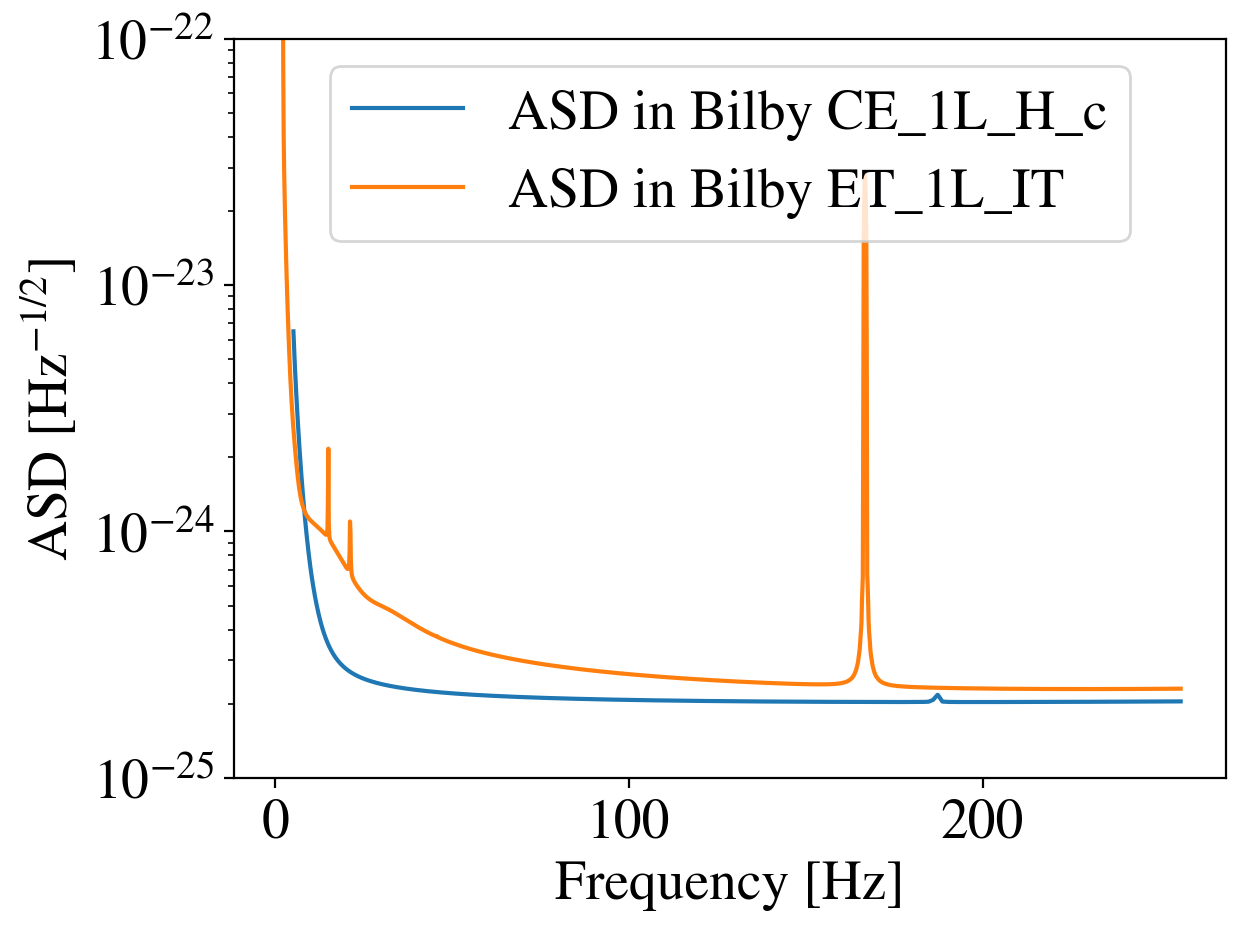

In [55]:
for ifo in asd_dataset_bilby_ET_CE.asds.keys():

    plt.plot(asd_dataset_bilby_ET_CE.domain.sample_frequencies, 
             asd_dataset_bilby_ET_CE.asds[ifo][0], 
        label = 'ASD in Bilby '+ifo)


plt.yscale('log')
plt.legend(loc = 'upper center')
#plt.xlim([0,256])

plt.ylabel('ASD [Hz$^{-1/2}$]')
plt.xlabel('Frequency [Hz]')

plt.ylim([1e-25,1e-22])
plt.show()

In [56]:
# c stands for correct

In [57]:
# repeating for ET-CE what has been done above for ET-2L A

# I need to use exactly the same ASD I used in Bilby 

########
# window factor is equal to 1 in my Bilby runs. 
########

ASD_bilby_ET_IT = pd.read_csv('../../2Ls/ETDelta_ET2L/result_event_252_nessai_ET2L_CE_c_zeronoise/ET_1L_IT_asd.dat', skiprows = 1, names = ['f', 'h(f)'], delimiter = ' ')

ASD_bilby_CE = pd.read_csv('../../2Ls/ETDelta_ET2L/result_event_252_nessai_ET2L_CE_c_zeronoise/CE_1L_H_c_asd.dat', skiprows = 1, names = ['f', 'h(f)'], delimiter = ' ')

ASD_bilby_ET_NL = pd.read_csv('../../2Ls/ETDelta_ET2L/result_event_252_nessai_ET2L_CE_c_zeronoise/ET_1L_NL_asd.dat', skiprows = 1, names = ['f', 'h(f)'], delimiter = ' ')


ind_freq = ASD_bilby_ET_IT['f'] <= 256
print('number of frequency bins = ', len(ASD_bilby_ET_IT.loc[ind_freq]))
print(ASD_bilby_ET_IT.loc[ind_freq])

#
# set settings      
settings = {"dataset_settings": {"T": 8.0, 
                                 "detectors": ["ET_1L_IT", "CE_1L_H_c", "ET_1L_NL"], 
                                 "f_s": 4096, 
                                 "num_psds_max": 1, #if set > 0, only a subset of all available PSDs will be used
                                 "observing_run": None ,
                                 "time_gap": 0, 
                                 "time_psd": 1024, 
                                 "window": {"roll_off": None, "type": "NoWindowFactor"}}, # with window type "NoWindowFactor", window_factor is set to 1 to match what in Bilby and roll_off also equal to Bilby
                                "domain_dict": {
                                        "delta_f": 0.125, 
                                        "f_max": 256.0, 
                                        "f_min": 6.0, 
                                        "type": "FrequencyDomain", 
                                        "window_factor": None}}

ET_dict = {"asds": {}, "gps_times": {}}

ET_dict["settings"] = settings

#
# I hacked train_builders.py and now works!
ET_dict["asds"]['ET_1L_IT'] = np.array(ASD_bilby_ET_IT['h(f)'].loc[ind_freq]).reshape(1,2049)
ET_dict["asds"]['CE_1L_H_c'] = np.array(ASD_bilby_CE['h(f)'].loc[ind_freq]).reshape(1,2049)
ET_dict["asds"]['ET_1L_NL'] = np.array(ASD_bilby_ET_NL['h(f)'].loc[ind_freq]).reshape(1,2049)

# equal to the reference time in training setting -> I don't know if this is correct!
ET_dict["gps_times"]['ET_1L_IT'] = 1126259462.391
ET_dict["gps_times"]['CE_1L_H_c'] = 1126259462.391
ET_dict["gps_times"]['ET_1L_NL'] = 1126259462.391


#print(ET_dict)

dataset = ASDDataset(dictionary=ET_dict) 
filename ='asds_ET2L_CE.hdf5' 
dataset.to_file(filename)

asd_dataset_bilby_ET_CE = ASDDataset(file_name = filename)
print(f"Dingo version: {asd_dataset_bilby_ET_CE.version}")
print("\nASD dataset\n" + "================\n")

print(f"Dataset size: {asd_dataset_bilby_ET_CE.length_info}\n")
print(f"GPS times (min/max): {asd_dataset_bilby_ET_CE.gps_info}")

print(
    "\nSettings\n"
    + "--------\n"
    + yaml.dump(
        asd_dataset_bilby_ET_CE.settings,
        default_flow_style=False,
        sort_keys=False,
    )
)


number of frequency bins =  2049
            f          h(f)
0       0.000           inf
1       0.125           inf
2       0.250           inf
3       0.375           inf
4       0.500           inf
...       ...           ...
2044  255.500  2.301429e-25
2045  255.625  2.301502e-25
2046  255.750  2.301577e-25
2047  255.875  2.301651e-25
2048  256.000  2.301725e-25

[2049 rows x 2 columns]
Dingo version: dingo=0.1.dev1015+gbf2c41f

ASD dataset

Dataset size: {'CE_1L_H_c': 1, 'ET_1L_IT': 1, 'ET_1L_NL': 1}

GPS times (min/max): {'CE_1L_H_c': 1126259462.391, 'ET_1L_IT': 1126259462.391, 'ET_1L_NL': 1126259462.391}

Settings
--------
dataset_settings:
  T: 8.0
  detectors:
  - ET_1L_IT
  - CE_1L_H_c
  - ET_1L_NL
  f_s: 4096
  num_psds_max: 1
  observing_run: null
  time_gap: 0
  time_psd: 1024
  window:
    roll_off: null
    type: NoWindowFactor
domain_dict:
  delta_f: 0.125
  f_max: 256.0
  f_min: 6.0
  type: FrequencyDomain
  window_factor: null



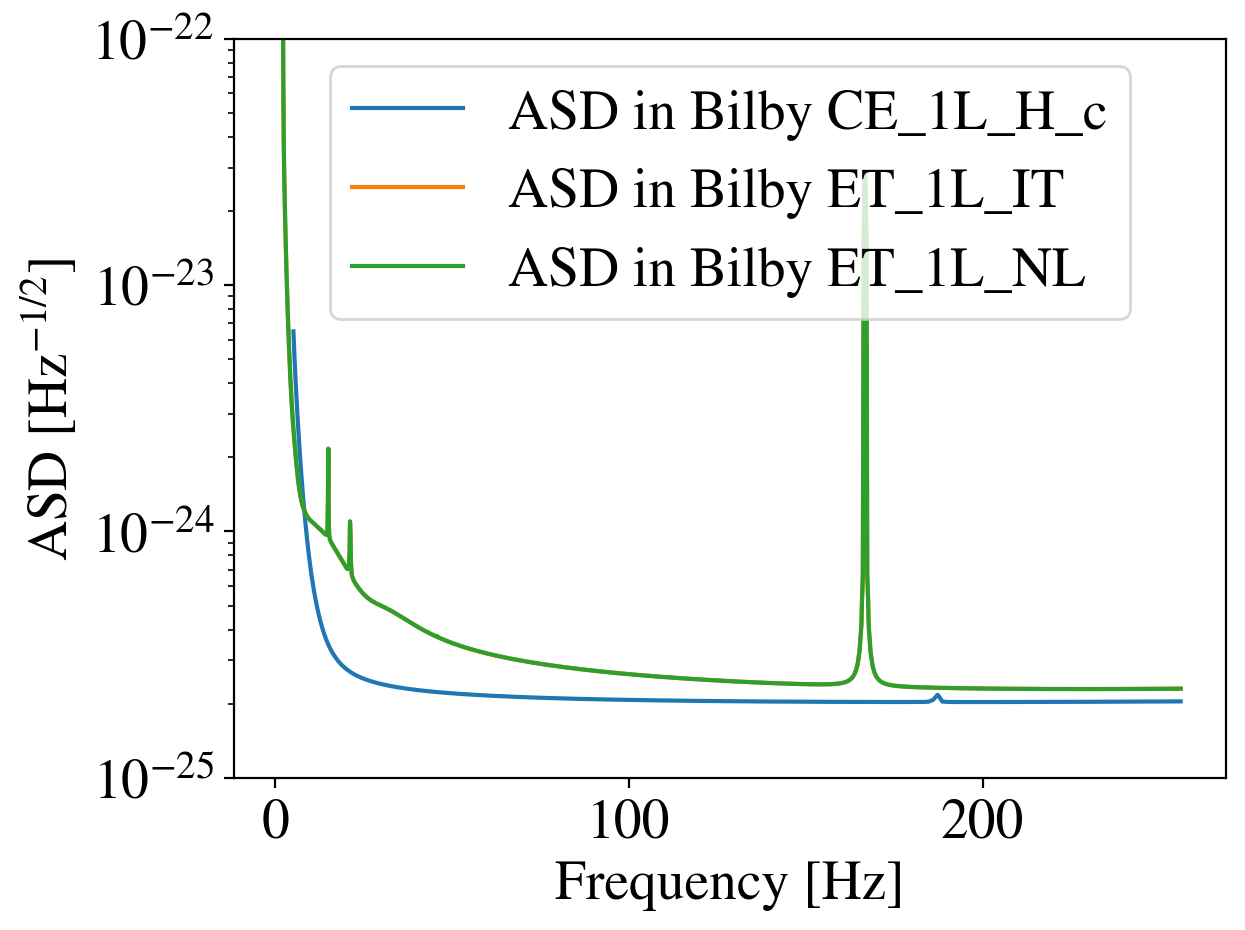

In [58]:
asd_dataset_bilby_ET_CE.asds.keys()

for ifo in asd_dataset_bilby_ET_CE.asds.keys():

    plt.plot(asd_dataset_bilby_ET_CE.domain.sample_frequencies, 
             asd_dataset_bilby_ET_CE.asds[ifo][0], 
        label = 'ASD in Bilby '+ifo)


plt.yscale('log')
plt.legend(loc = 'upper center')
#plt.xlim([0,256])

plt.ylabel('ASD [Hz$^{-1/2}$]')
plt.xlabel('Frequency [Hz]')

plt.ylim([1e-25,1e-22])
plt.show()

In [59]:
#  ET-Delta + CE

ASD_bilby_ET_1 = pd.read_csv('../../2Ls/ETDelta_ET2L/result_event_252_nessai_ETDelta_CE_c_zeronoise/ET-dingo1_asd.dat', skiprows = 1, names = ['f', 'h(f)'], delimiter = ' ')

ASD_bilby_ET_2 = pd.read_csv('../../2Ls/ETDelta_ET2L/result_event_252_nessai_ETDelta_CE_c_zeronoise/ET-dingo2_asd.dat', skiprows = 1, names = ['f', 'h(f)'], delimiter = ' ')

ASD_bilby_ET_3 = pd.read_csv('../../2Ls/ETDelta_ET2L/result_event_252_nessai_ETDelta_CE_c_zeronoise/ET-dingo3_asd.dat', skiprows = 1, names = ['f', 'h(f)'], delimiter = ' ')

ASD_bilby_CE = pd.read_csv('../../2Ls/ETDelta_ET2L/result_event_252_nessai_ETDelta_CE_c_zeronoise/CE_1L_H_c_asd.dat', skiprows = 1, names = ['f', 'h(f)'], delimiter = ' ')



ind_freq = ASD_bilby_ET_1['f'] <= 256
print('number of frequency bins = ', len(ASD_bilby_ET_1.loc[ind_freq]))
print(ASD_bilby_ET_1.loc[ind_freq])

#
# set settings      
settings = {"dataset_settings": {"T": 8.0, 
                                 "detectors": ["ET-dingo1", "ET-dingo2", "ET-dingo3", "CE_1L_H_c"], 
                                 "f_s": 4096, 
                                 "num_psds_max": 1, #if set > 0, only a subset of all available PSDs will be used
                                 "observing_run": None ,
                                 "time_gap": 0, 
                                 "time_psd": 1024, 
                                 "window": {"roll_off": None, "type": "NoWindowFactor"}}, # with window type "NoWindowFactor", window_factor is set to 1 to match what in Bilby and roll_off also equal to Bilby
                                "domain_dict": {
                                        "delta_f": 0.125, 
                                        "f_max": 256.0, 
                                        "f_min": 6.0, 
                                        "type": "FrequencyDomain", 
                                        "window_factor": None}}

ET_dict = {"asds": {}, "gps_times": {}}

ET_dict["settings"] = settings

#
# I hacked train_builders.py and now works!
ET_dict["asds"]['ET-dingo1'] = np.array(ASD_bilby_ET_1['h(f)'].loc[ind_freq]).reshape(1,2049)
ET_dict["asds"]['ET-dingo2'] = np.array(ASD_bilby_ET_2['h(f)'].loc[ind_freq]).reshape(1,2049)
ET_dict["asds"]['ET-dingo3'] = np.array(ASD_bilby_ET_3['h(f)'].loc[ind_freq]).reshape(1,2049)
ET_dict["asds"]['CE_1L_H_c'] = np.array(ASD_bilby_CE['h(f)'].loc[ind_freq]).reshape(1,2049)


# equal to the reference time in training setting -> I don't know if this is correct!
ET_dict["gps_times"]['ET-dingo1'] = 1126259462.391
ET_dict["gps_times"]['ET-dingo2'] = 1126259462.391
ET_dict["gps_times"]['ET-dingo3'] = 1126259462.391
ET_dict["gps_times"]['CE_1L_H_c'] = 1126259462.391


#print(ET_dict)

dataset = ASDDataset(dictionary=ET_dict) 
filename ='asds_ETDelta_CE.hdf5' 
dataset.to_file(filename)

asd_dataset_bilby_ETDelta_CE = ASDDataset(file_name = filename)
print(f"Dingo version: {asd_dataset_bilby_ETDelta_CE.version}")
print("\nASD dataset\n" + "================\n")

print(f"Dataset size: {asd_dataset_bilby_ETDelta_CE.length_info}\n")
print(f"GPS times (min/max): {asd_dataset_bilby_ETDelta_CE.gps_info}")

print(
    "\nSettings\n"
    + "--------\n"
    + yaml.dump(
        asd_dataset_bilby_ETDelta_CE.settings,
        default_flow_style=False,
        sort_keys=False,
    )
)


number of frequency bins =  2049
            f          h(f)
0       0.000           inf
1       0.125           inf
2       0.250           inf
3       0.375           inf
4       0.500           inf
...       ...           ...
2044  255.500  3.106134e-25
2045  255.625  3.106086e-25
2046  255.750  3.106040e-25
2047  255.875  3.105993e-25
2048  256.000  3.105947e-25

[2049 rows x 2 columns]
Dingo version: dingo=0.1.dev1015+gbf2c41f

ASD dataset

Dataset size: {'CE_1L_H_c': 1, 'ET-dingo1': 1, 'ET-dingo2': 1, 'ET-dingo3': 1}

GPS times (min/max): {'CE_1L_H_c': 1126259462.391, 'ET-dingo1': 1126259462.391, 'ET-dingo2': 1126259462.391, 'ET-dingo3': 1126259462.391}

Settings
--------
dataset_settings:
  T: 8.0
  detectors:
  - ET-dingo1
  - ET-dingo2
  - ET-dingo3
  - CE_1L_H_c
  f_s: 4096
  num_psds_max: 1
  observing_run: null
  time_gap: 0
  time_psd: 1024
  window:
    roll_off: null
    type: NoWindowFactor
domain_dict:
  delta_f: 0.125
  f_max: 256.0
  f_min: 6.0
  type: FrequencyDomai

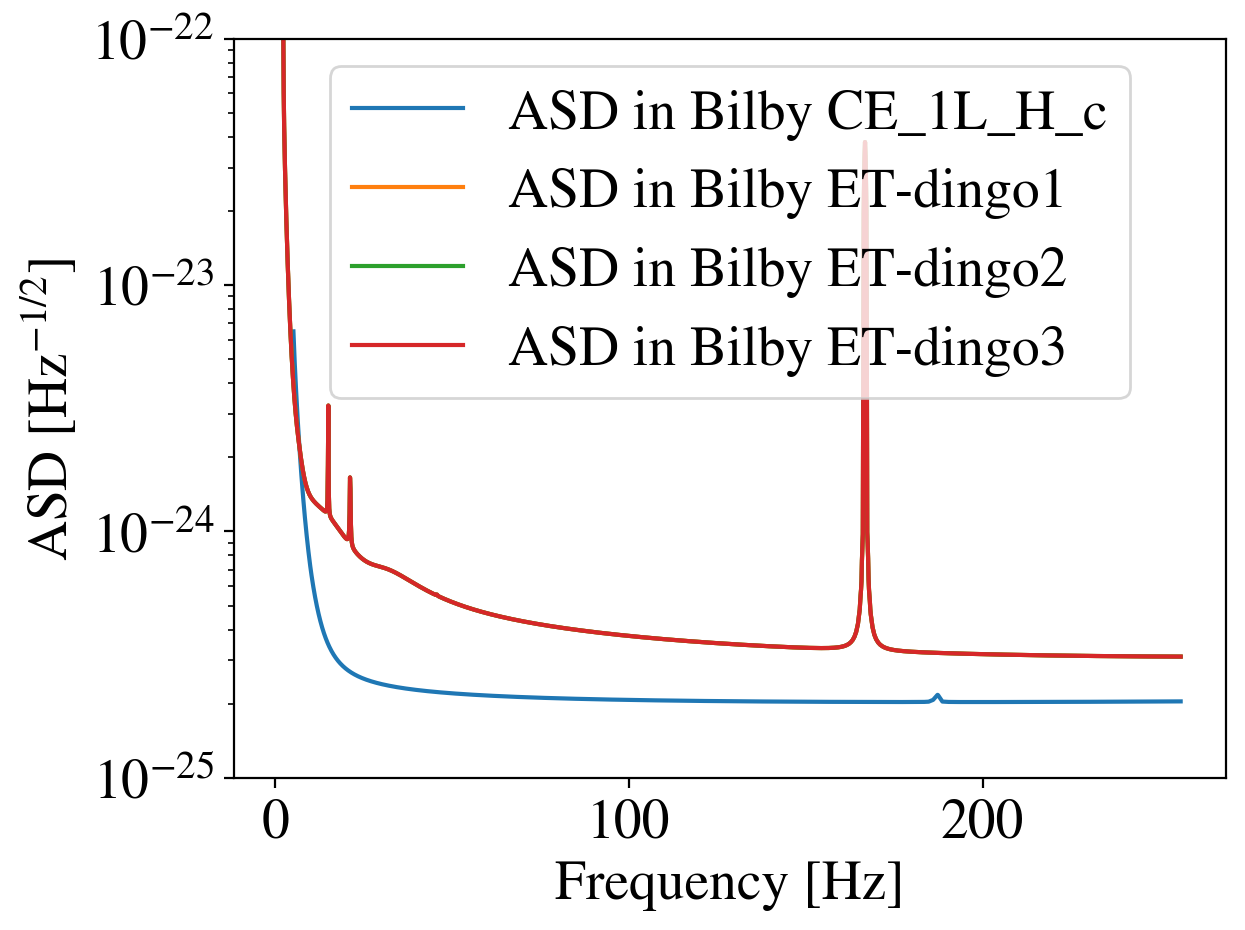

In [60]:
asd_dataset_bilby_ETDelta_CE.asds.keys()

for ifo in asd_dataset_bilby_ETDelta_CE.asds.keys():

    plt.plot(asd_dataset_bilby_ETDelta_CE.domain.sample_frequencies, 
             asd_dataset_bilby_ETDelta_CE.asds[ifo][0], 
        label = 'ASD in Bilby '+ifo)


plt.yscale('log')
plt.legend(loc = 'upper center')
#plt.xlim([0,256])

plt.ylabel('ASD [Hz$^{-1/2}$]')
plt.xlabel('Frequency [Hz]')

plt.ylim([1e-25,1e-22])
plt.show()

In [62]:
#  ET-2L + LIGO India

ASD_bilby_ET_IT = pd.read_csv('../../2Ls/ETDelta_ET2L/result_event_252_nessai_ET2L_LIGOIndia_zeronoise/ET_1L_IT_asd.dat', skiprows = 1, names = ['f', 'h(f)'], delimiter = ' ')

ASD_bilby_ET_NL = pd.read_csv('../../2Ls/ETDelta_ET2L/result_event_252_nessai_ET2L_LIGOIndia_zeronoise/ET_1L_NL_asd.dat', skiprows = 1, names = ['f', 'h(f)'], delimiter = ' ')

ASD_bilby_LIGOIndia = pd.read_csv('../../2Ls/ETDelta_ET2L/result_event_252_nessai_ET2L_LIGOIndia_zeronoise/LIGO_India_O5_asd.dat', skiprows = 1, names = ['f', 'h(f)'], delimiter = ' ')



ind_freq = ASD_bilby_ET_IT['f'] <= 256
print('number of frequency bins = ', len(ASD_bilby_ET_IT.loc[ind_freq]))
print(ASD_bilby_ET_IT.loc[ind_freq])

#
# set settings      
settings = {"dataset_settings": {"T": 8.0, 
                                 "detectors": ["ET_1L_IT", "ET_1L_NL", "LIGO_India_O5"], 
                                 "f_s": 4096, 
                                 "num_psds_max": 1, #if set > 0, only a subset of all available PSDs will be used
                                 "observing_run": None ,
                                 "time_gap": 0, 
                                 "time_psd": 1024, 
                                 "window": {"roll_off": None, "type": "NoWindowFactor"}}, # with window type "NoWindowFactor", window_factor is set to 1 to match what in Bilby and roll_off also equal to Bilby
                                "domain_dict": {
                                        "delta_f": 0.125, 
                                        "f_max": 256.0, 
                                        "f_min": 6.0, 
                                        "type": "FrequencyDomain", 
                                        "window_factor": None}}

ET_dict = {"asds": {}, "gps_times": {}}

ET_dict["settings"] = settings

#
# I hacked train_builders.py and now works!
ET_dict["asds"]['ET_1L_IT'] = np.array(ASD_bilby_ET_IT['h(f)'].loc[ind_freq]).reshape(1,2049)
ET_dict["asds"]['ET_1L_NL'] = np.array(ASD_bilby_ET_NL['h(f)'].loc[ind_freq]).reshape(1,2049)
ET_dict["asds"]['LIGO_India_O5'] = np.array(ASD_bilby_LIGOIndia['h(f)'].loc[ind_freq]).reshape(1,2049)


# equal to the reference time in training setting -> I don't know if this is correct!
ET_dict["gps_times"]['ET_1L_IT'] = 1126259462.391
ET_dict["gps_times"]['ET_1L_NL'] = 1126259462.391
ET_dict["gps_times"]['LIGO_India_O5'] = 1126259462.391



#print(ET_dict)

dataset = ASDDataset(dictionary=ET_dict) 
filename ='asds_ET2L_LIGOIndia.hdf5' 
dataset.to_file(filename)

asd_dataset_bilby_ET2L_LIGOIndia = ASDDataset(file_name = filename)
print(f"Dingo version: {asd_dataset_bilby_ET2L_LIGOIndia.version}")
print("\nASD dataset\n" + "================\n")

print(f"Dataset size: {asd_dataset_bilby_ET2L_LIGOIndia.length_info}\n")
print(f"GPS times (min/max): {asd_dataset_bilby_ET2L_LIGOIndia.gps_info}")

print(
    "\nSettings\n"
    + "--------\n"
    + yaml.dump(
        asd_dataset_bilby_ET2L_LIGOIndia.settings,
        default_flow_style=False,
        sort_keys=False,
    )
)


number of frequency bins =  2049
            f          h(f)
0       0.000           inf
1       0.125           inf
2       0.250           inf
3       0.375           inf
4       0.500           inf
...       ...           ...
2044  255.500  2.301429e-25
2045  255.625  2.301502e-25
2046  255.750  2.301577e-25
2047  255.875  2.301651e-25
2048  256.000  2.301725e-25

[2049 rows x 2 columns]
Dingo version: dingo=0.1.dev1015+gbf2c41f

ASD dataset

Dataset size: {'ET_1L_IT': 1, 'ET_1L_NL': 1, 'LIGO_India_O5': 1}

GPS times (min/max): {'ET_1L_IT': 1126259462.391, 'ET_1L_NL': 1126259462.391, 'LIGO_India_O5': 1126259462.391}

Settings
--------
dataset_settings:
  T: 8.0
  detectors:
  - ET_1L_IT
  - ET_1L_NL
  - LIGO_India_O5
  f_s: 4096
  num_psds_max: 1
  observing_run: null
  time_gap: 0
  time_psd: 1024
  window:
    roll_off: null
    type: NoWindowFactor
domain_dict:
  delta_f: 0.125
  f_max: 256.0
  f_min: 6.0
  type: FrequencyDomain
  window_factor: null



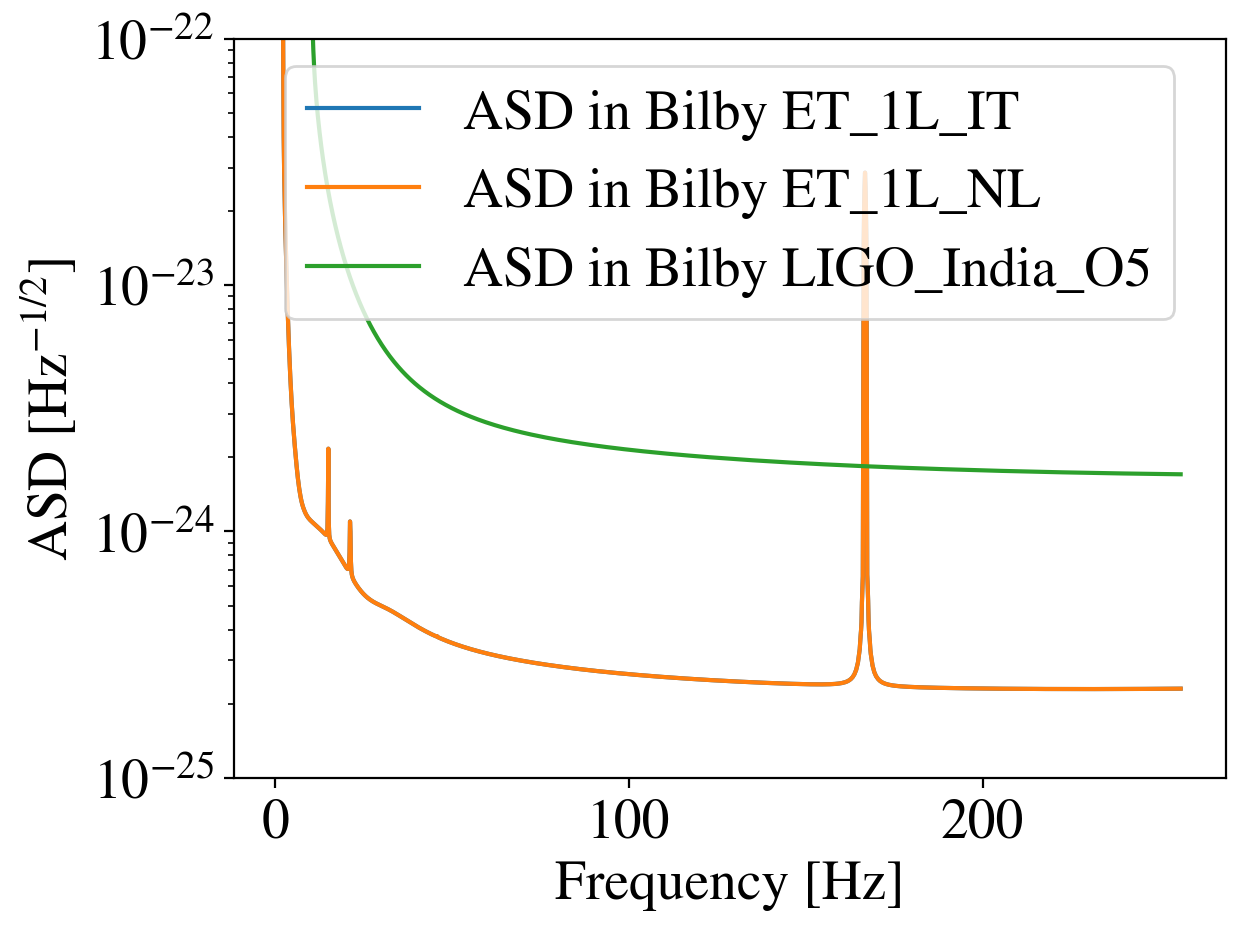

In [63]:
asd_dataset_bilby_ET2L_LIGOIndia.asds.keys()

for ifo in asd_dataset_bilby_ET2L_LIGOIndia.asds.keys():

    plt.plot(asd_dataset_bilby_ET2L_LIGOIndia.domain.sample_frequencies, 
             asd_dataset_bilby_ET2L_LIGOIndia.asds[ifo][0], 
        label = 'ASD in Bilby '+ifo)


plt.yscale('log')
plt.legend(loc = 'upper center')
#plt.xlim([0,256])

plt.ylabel('ASD [Hz$^{-1/2}$]')
plt.xlabel('Frequency [Hz]')

plt.ylim([1e-25,1e-22])
plt.show()